# Theano on the CIFAR-100 Dataset

## CIFAR-100 Dataset:
Similar to the CIFAR-10, this dataset comprises 100 classes with a total of 600 images. For each class, there are 500 training photos and 100 test images. The CIFAR-100's 100 classes are divided into 20 super classes. Each image has a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

The list of classes in the CIFAR-10 dataset are listed below:

![title](CIFAR100.png)

In [1]:
import os
# Toggling between CPU and GPU
# GPU in use is NVIDIA GEFORCE 940M
# Theano backend is being used for keras
# To make the GPU unavailable, uncomment the line of code below
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from tensorflow.keras.callbacks import TensorBoard
file_name = 'my_save_model'
tensorboard = TensorBoard(log_dir="logs\\{}".format(file_name))

In [3]:
import numpy as np
import time
import datetime
#from time import time
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.layers import *
from keras.models import *
import matplotlib.pyplot as plt

import sys,humanize,psutil,GPUtil

Using Theano backend.


In [4]:
# Loading the dataset
(train_images, train_labels), (validation_images, validation_labels) = cifar100.load_data()
print("Training dataset")
print(train_images.shape)
print(train_labels.shape)
print('Validation dataset:')
print(validation_images.shape)
print(validation_labels.shape)

Training dataset
(50000, 3, 32, 32)
(50000, 1)
Validation dataset:
(10000, 3, 32, 32)
(10000, 1)


In [5]:
# Determining the dataset characteristics
print('Training Images: {}'.format(train_images.shape))
print('Testing Images: {}'.format(validation_images.shape))

Training Images: (50000, 3, 32, 32)
Testing Images: (10000, 3, 32, 32)


In [6]:
# Now for a single image 
print(train_images[0].shape)

(3, 32, 32)


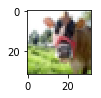

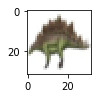

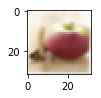

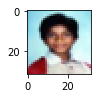

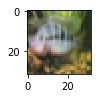

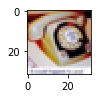

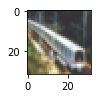

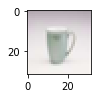

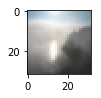

In [7]:
# Visualize images in a Grid of 3x3 images
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = train_images[i].transpose([1,2,0])
    plt.imshow(img)
    
    # show the plot
    plt.show()

In [8]:
# Building a convolutional neural network for object recognition on Cifar10 data.

# fix random seed for reproducibility
seed = 6
np.random.seed(seed) 

# load the data
(train_images, train_labels), (validation_images, validation_labels) = cifar100.load_data()

rows, cols = 32, 32
train_images = train_images.reshape(train_images.shape[0], 3, 32, 32)
validation_images = validation_images.reshape(validation_images.shape[0], 3, 32, 32)

input_shape = (3, rows, cols)

# normalize the inputs from 0-255 to 0.0-1.0
train_images = train_images.astype('float32')
validation_images = validation_images.astype('float32')
train_images = train_images / 255.0
validation_images = validation_images / 255.0

In [9]:
# class labels shape
print(train_labels.shape)
print(train_labels[0])

(50000, 1)
[19]


In [10]:
# hot encode outputs
train_labels = np_utils.to_categorical(train_labels)
validation_labels = np_utils.to_categorical(validation_labels)
num_classes = validation_labels.shape[1]

print(train_labels.shape)
print(train_labels[0])

(50000, 100)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [11]:
# Model Buiding
model = Sequential()

# Layer 1
# Convolution 1: Filters as we know is 6. Filter size is 5x5, relu is the activation function
model.add(Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'relu', input_shape=input_shape))
# Pooling Layer 1
model.add(MaxPooling2D(pool_size = 2, strides = 2))

# Layer 2
# Convolution 2: Input = 14x14x6. Output = 10x10x16 Conv2d
model.add(Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'relu', input_shape=(6,14,14)))
# Pooling Layer 2
model.add(MaxPooling2D(pool_size = 2, strides = 2))

# Flatten 
model.add(Flatten())

# Layer 3
# Fully Connected Layer 1
model.add(Dense(units= 120, activation = 'relu'))

# Layer 4
# Fully Connected Layer 2
model.add(Dense(units= 84, activation = 'relu'))

# Layer 5
# Output Laer
model.add(Dense(units= 100, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 28, 28)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 14, 14)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 10, 10)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 5, 5)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [12]:
# from keras.optimizers import SGD
# define hyper parameters
learning_rate = 0.01
weight_decay = 1e-6
momentum = 0.9

t1 = time.time()
# define optimizer and compile model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
# Define function (For CPU) Memory Report
def cpu_mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

  # Getting usage of cpu virtual_memory in GB
  print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
  # Getting % usage of cpu virtual_memory
  print('CPU RAM % used: ', psutil.virtual_memory()[2])

In [14]:
# Define function (For GPU) Memory Report
def gpu_mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

In [15]:
# Train model
t1 = time.time()

# Training for 10 epochs and a batch size of 10
history = model.fit( train_images, train_labels, verbose=1, epochs = 10, batch_size = 10, validation_split = 0.2, callbacks=[tensorboard])
#model.fit(train_images[:20000], train_labels[:20000], epochs = , batch_size = 10)
t2 = time.time() 
print("Training Time: ", t2-t1)
#cpu_mem_report()
gpu_mem_report()

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 49s 1ms/step - loss: 3.9681 - acc: 0.0871 - val_loss: 3.6510 - val_acc: 0.1453
Epoch 2/10
40000/40000 [==============================] - 52s 1ms/step - loss: 3.4383 - acc: 0.1774 - val_loss: 3.3683 - val_acc: 0.1913
Epoch 3/10
40000/40000 [==============================] - 56s 1ms/step - loss: 3.2249 - acc: 0.2159 - val_loss: 3.2469 - val_acc: 0.2197
Epoch 4/10
40000/40000 [==============================] - 54s 1ms/step - loss: 3.0956 - acc: 0.2409 - val_loss: 3.1824 - val_acc: 0.2308
Epoch 5/10
40000/40000 [==============================] - 50s 1ms/step - loss: 2.9957 - acc: 0.2560 - val_loss: 3.1765 - val_acc: 0.2423
Epoch 6/10
40000/40000 [==============================] - 46s 1ms/step - loss: 2.9219 - acc: 0.2713 - val_loss: 3.1765 - val_acc: 0.2326
Epoch 7/10
40000/40000 [==============================] - 47s 1ms/step - loss: 2.8495 - acc: 0.2865 - val_loss: 3.1230 - val_acc

In [16]:
# Evaluating the framework on the Test dataset
t1 = time.time()

#test_loss, test_acc = model.evaluate(validation_images, validation_labels, verbose=2)
#print("Testing Loss: ", test_loss)
#print("Testing Accuracy: ", test_acc*100,"%")

_, acc = model.evaluate(validation_images, validation_labels)
print("Accuracy = ", (acc*100.0), "%")

t2 = time.time() 
print("Testing Time: ", t2-t1)

10000/10000 [==============================] - 3s 273us/step
Accuracy =  25.36 %
Testing Time:  2.731797695159912


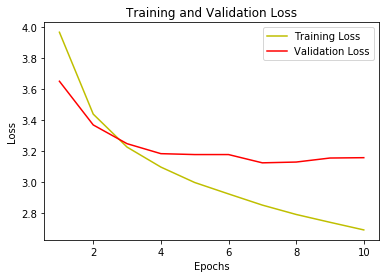

In [17]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss,'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

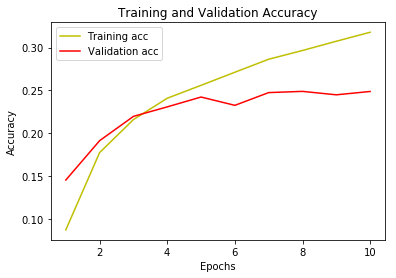

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc,'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()